In [1]:
# Import libraries and setup configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.seasonal import STL
from urllib.parse import urlparse
import re
from collections import defaultdict
import networkx as nx
from joblib import parallel_backend
import sys
from tqdm import tqdm

# Initialize configurations
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', 50)
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tefer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tefer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset with robust error handling
print("Loading dataset...")
try:
    df = pd.read_csv('fnspid_dataset.csv', parse_dates=['date'])
    df.set_index('date', inplace=True)
    print(f"Dataset loaded successfully with {len(df)} records")
    display(df.head(3))
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    sys.exit(1)

Loading dataset...
Dataset loaded successfully with 1407328 records


,Unnamed: 0,headline,url,publisher,stock
date,,,,,
2020-06-05 10:30:54-04:00,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A
2020-06-03 10:45:20-04:00,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A
2020-05-26 04:30:07-04:00,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A



=== ENHANCED DESCRIPTIVE STATISTICS ===

Text Statistics:


,count,mean,std,min,25%,50%,75%,max
Character Count,1407328.0,73.12,40.74,3.0,47.0,64.0,87.0,512.0
Word Count,1407328.0,11.42,6.35,1.0,7.0,10.0,13.0,77.0


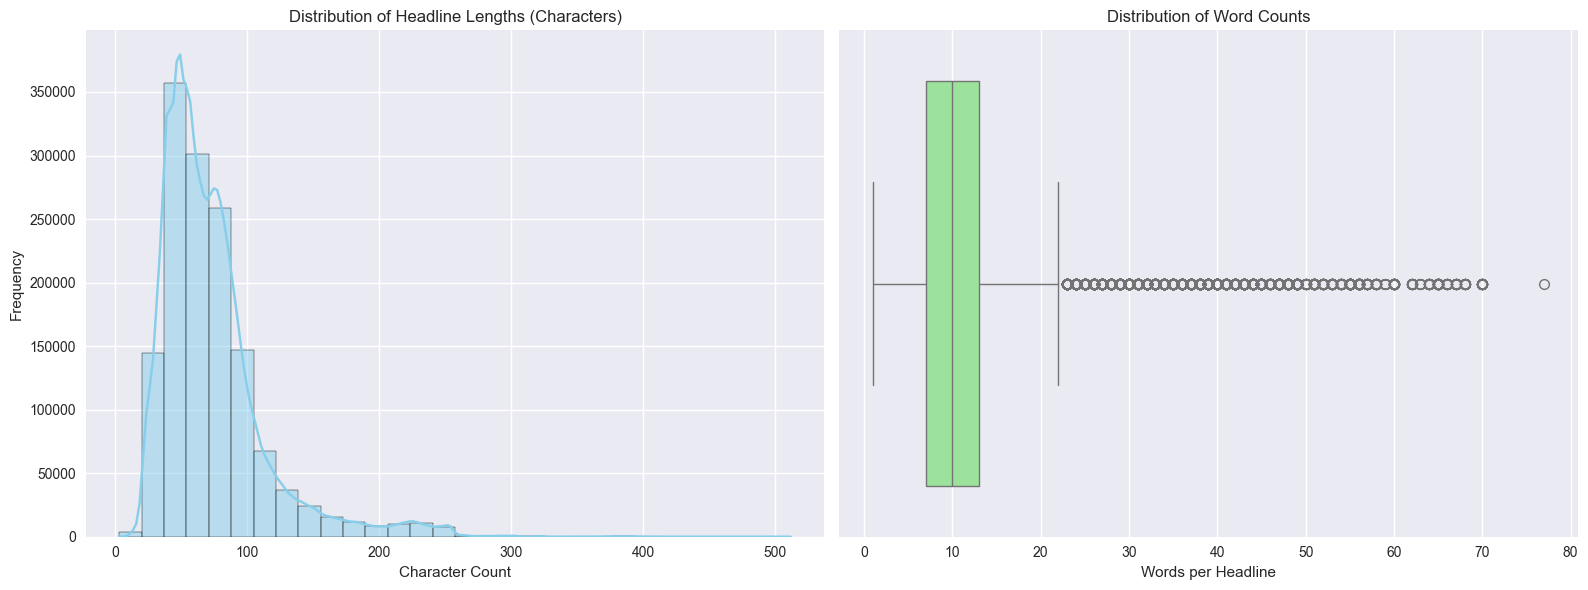

In [3]:
# Enhanced Descriptive Statistics
print("\n=== ENHANCED DESCRIPTIVE STATISTICS ===")

# Text length analysis with multiple metrics
df['headline_length'] = df['headline'].apply(len)
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))

# Create a summary statistics table
stats_df = pd.DataFrame({
    'Character Count': df['headline_length'].describe(),
    'Word Count': df['word_count'].describe()
}).T.round(2)

print("\nText Statistics:")
display(stats_df)

# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Character count distribution
sns.histplot(df['headline_length'], bins=30, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Headline Lengths (Characters)')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')

# Word count distribution
sns.boxplot(x=df['word_count'], ax=ax2, color='lightgreen')
ax2.set_title('Distribution of Word Counts')
ax2.set_xlabel('Words per Headline')

plt.tight_layout()
plt.show()

In [4]:
# Optimized Text Preprocessing
print("\n=== OPTIMIZED TEXT PROCESSING ===")

# Sample data if too large
working_df = df.sample(10000, random_state=42) if len(df) > 10000 else df.copy()

# Enhanced text preprocessing
stop_words = set(stopwords.words('english')) | {'said', 'company', 'inc', 'llc', 'corp'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', str(text))
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Lemmatize and filter
    tokens = [lemmatizer.lemmatize(t) for t in tokens 
              if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

print("Cleaning text with progress tracking...")
tqdm.pandas()
working_df['cleaned_text'] = working_df['headline'].progress_apply(clean_text)

# Show before/after examples
print("\nText Cleaning Examples:")
sample_texts = working_df[['headline', 'cleaned_text']].sample(3, random_state=42)
display(sample_texts)


=== OPTIMIZED TEXT PROCESSING ===
Cleaning text with progress tracking...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.56it/s]


Text Cleaning Examples:


,headline,cleaned_text
date,,
2019-07-29 00:00:00,Lexicon Shares Fall 47% On Termination Of Lice...,lexicon share fall termination license agreeme...
2020-02-25 00:00:00,Raymond James Maintains Outperform on Tandem D...,raymond james maintains outperform tandem diab...
2017-07-26 00:00:00,"Earnings Scheduled For July 26, 2017",earnings scheduled july


In [5]:
# Cell 5: Topic Modeling with Robust Visualization
print("\n=== TOPIC MODELING ===")

# Optimized Vectorization
print("Creating document-term matrix...")
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=5000,
    ngram_range=(1,2),  # Include bigrams
    stop_words='english'
)
dtm = vectorizer.fit_transform(working_df['cleaned_text'])
vocab = vectorizer.get_feature_names_out()

# Optimized LDA Model
print("Training LDA model (this may take several minutes)...")
lda = LatentDirichletAllocation(
    n_components=5,
    learning_method='online',
    batch_size=512,  # Increased batch size
    max_iter=25,     # Increased iterations
    random_state=42,
    n_jobs=-1
)

with parallel_backend('threading'):
    lda.fit(dtm)

# Enhanced topic display
def show_topics(model, feature_names, n_top_words=15):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [(feature_names[i], topic[i]) 
                        for i in topic.argsort()[:-n_top_words-1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_features
    return topics

topic_results = show_topics(lda, vocab)

# Display topics with weights
print("\nDiscovered Topics with Word Weights:")
for topic, words in topic_results.items():
    print(f"\n{topic}:")
    display(pd.DataFrame(words, columns=['Word', 'Weight']).set_index('Word'))


=== TOPIC MODELING ===
Creating document-term matrix...
Training LDA model (this may take several minutes)...

Discovered Topics with Word Weights:

Topic 1:


,Weight
Word,
stock,449.467955
share,386.162172
update,307.680517
market,294.859862
etf,240.667935
week,207.925888
market update,176.992794
hit,176.381000
hit week,159.981528



Topic 2:


,Weight
Word,
share,651.316096
stock,565.382694
trading,388.860198
session,368.046301
moving,333.892770
stock moving,323.381094
higher,309.897293
premarket,297.350913
company,257.643172



Topic 3:


,Weight
Word,
est,1042.568878
eps,957.902139
report,886.365738
sale,597.685218
eps est,411.234916
report eps,392.920388
estimate,363.425751
earnings,339.901416
revenue,300.634410



Topic 4:


,Weight
Word,
maintains,367.109264
downgrade,344.795386
target,338.441871
benzingas,330.791394
market,328.767434
price,309.498795
price target,296.276865
raise,290.767106
lower,235.677369



Topic 5:


,Weight
Word,
stock,357.780383
buy,354.189043
announces,344.922629
new,297.373255
week,288.047595
initiate,264.294111
high,257.010085
coverage,239.061900
initiate coverage,215.642707



=== TOPIC VISUALIZATIONS ===


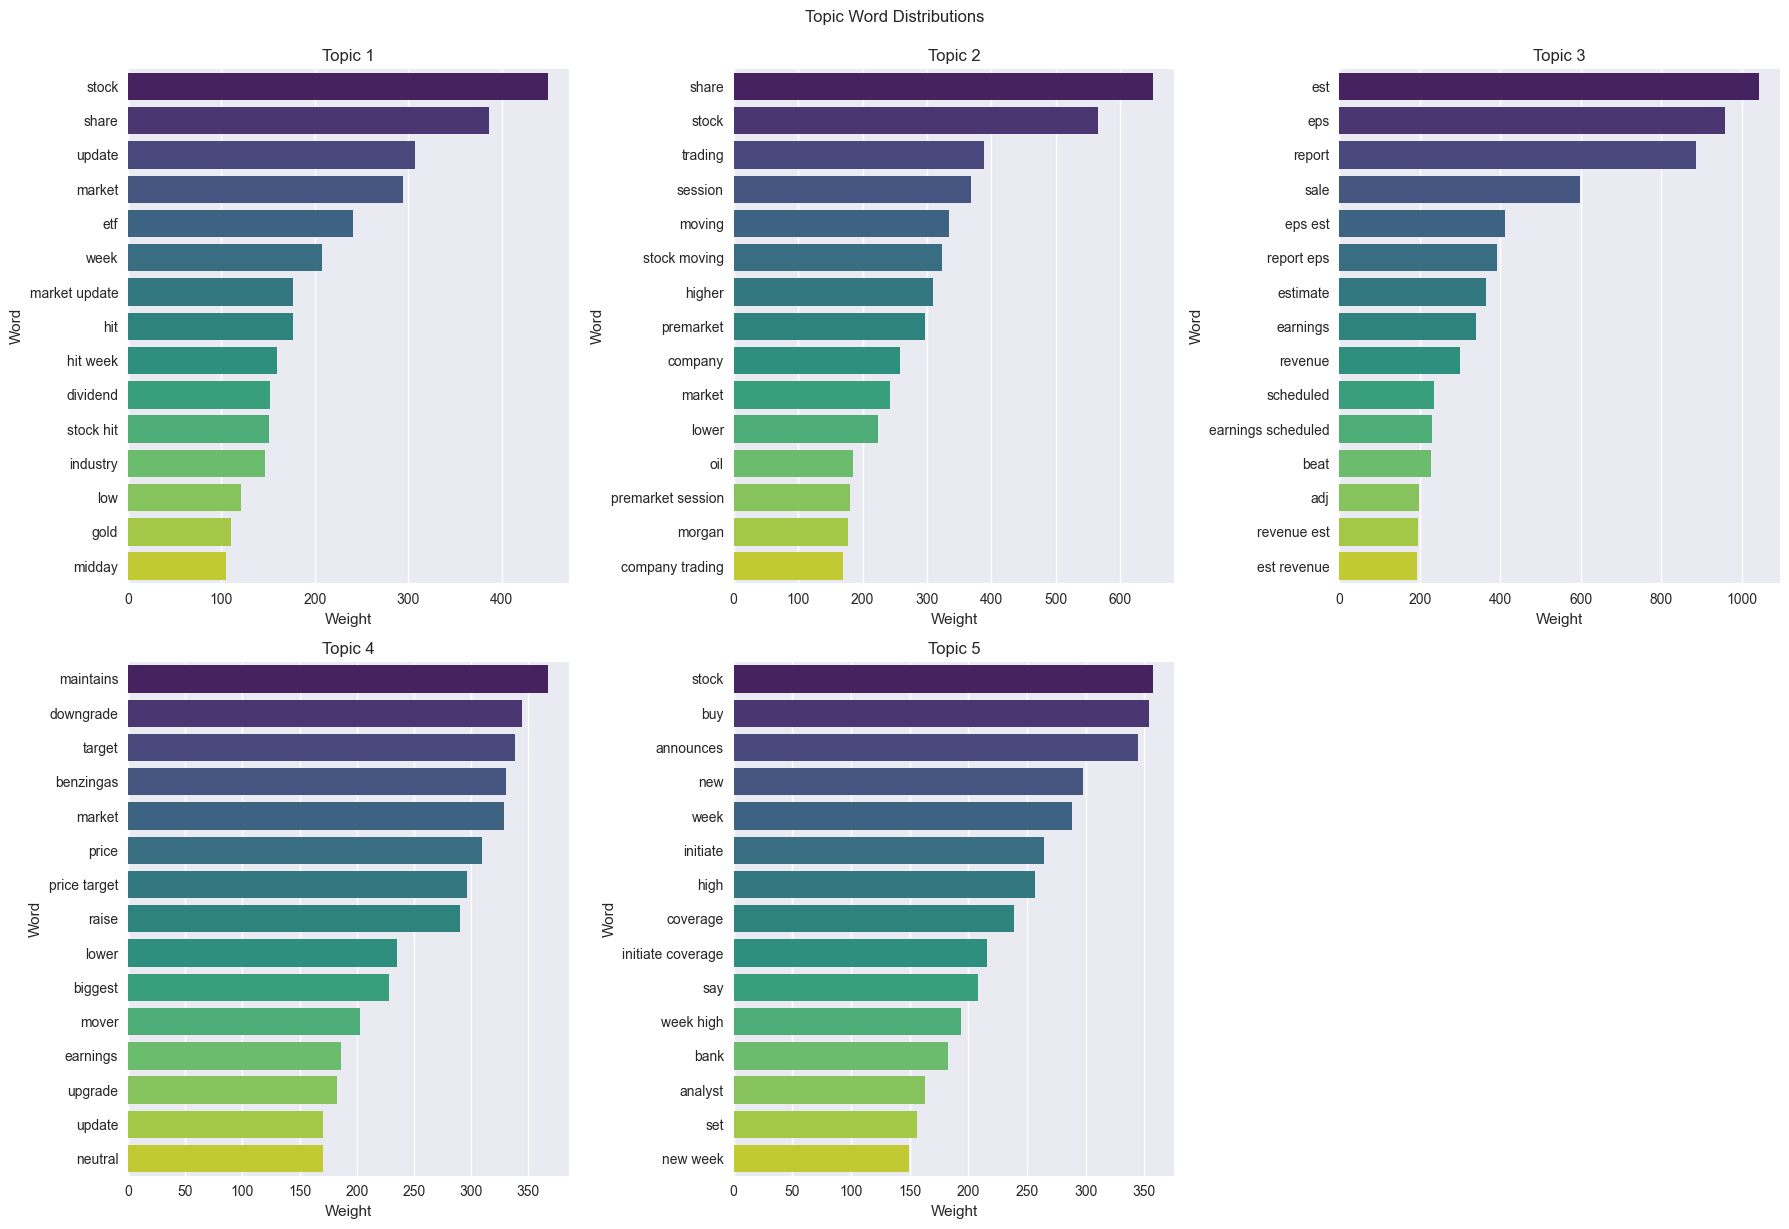

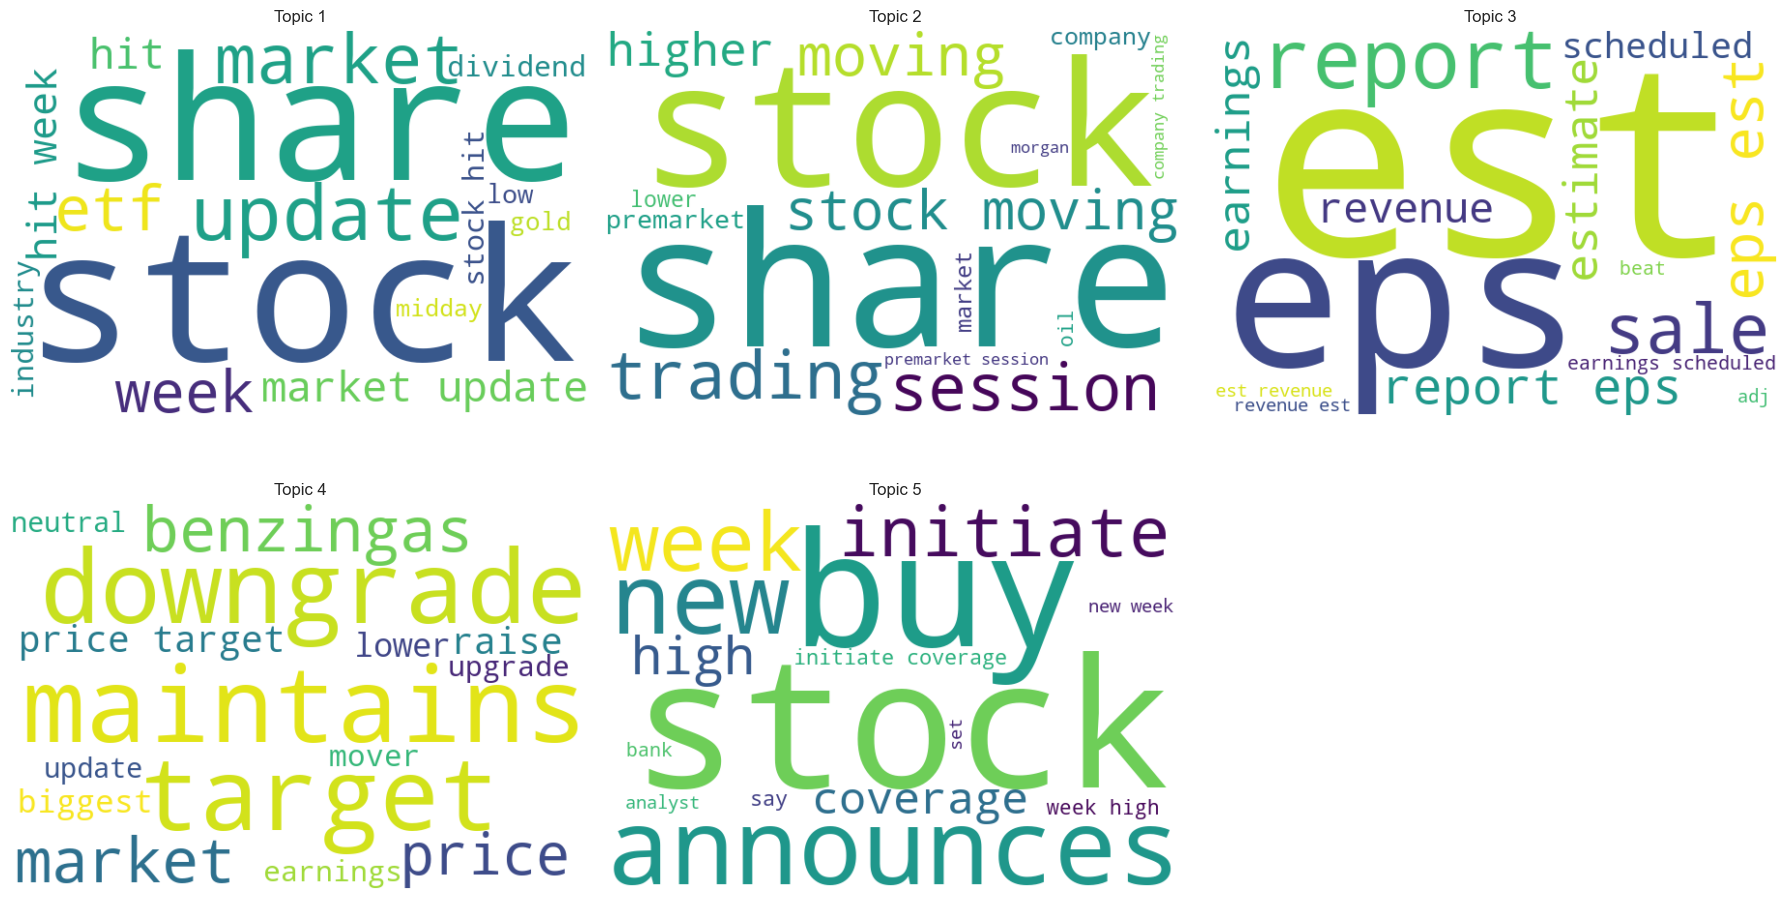

In [6]:
# Enhanced Topic Visualizations (Fixed Version)
print("\n=== TOPIC VISUALIZATIONS ===")

try:
    # Create bar charts for each topic with fixed palette warnings
    plt.figure(figsize=(18, 12))
    for i, (topic, words) in enumerate(topic_results.items()):
        plt.subplot(2, 3, i+1)
        words_df = pd.DataFrame(words, columns=['Word', 'Weight'])
        
        # Updated barplot syntax to avoid warnings
        sns.barplot(
            y='Word', 
            x='Weight', 
            data=words_df, 
            hue='Word',  # Added hue parameter
            palette='viridis', 
            dodge=False,  # Prevent splitting by hue
            legend=False  # Hide legend since we don't need it
        )
        plt.title(topic)
        plt.tight_layout()
    plt.suptitle('Topic Word Distributions', y=1.02)
    plt.show()
    
    # Create word clouds if available
    try:
        from wordcloud import WordCloud
        
        plt.figure(figsize=(18, 10))
        for i, (topic, words) in enumerate(topic_results.items()):
            plt.subplot(2, 3, i+1)
            wordcloud = WordCloud(
                width=600, 
                height=400, 
                background_color='white',
                colormap='viridis'
            ).generate_from_frequencies(dict(words))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(topic)
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("WordCloud package not available - install with: pip install wordcloud")
        
except Exception as e:
    print(f"Visualization error: {str(e)}")


=== TIME SERIES ANALYSIS ===
Timezone detected: UTC-04:00 - converting to UTC


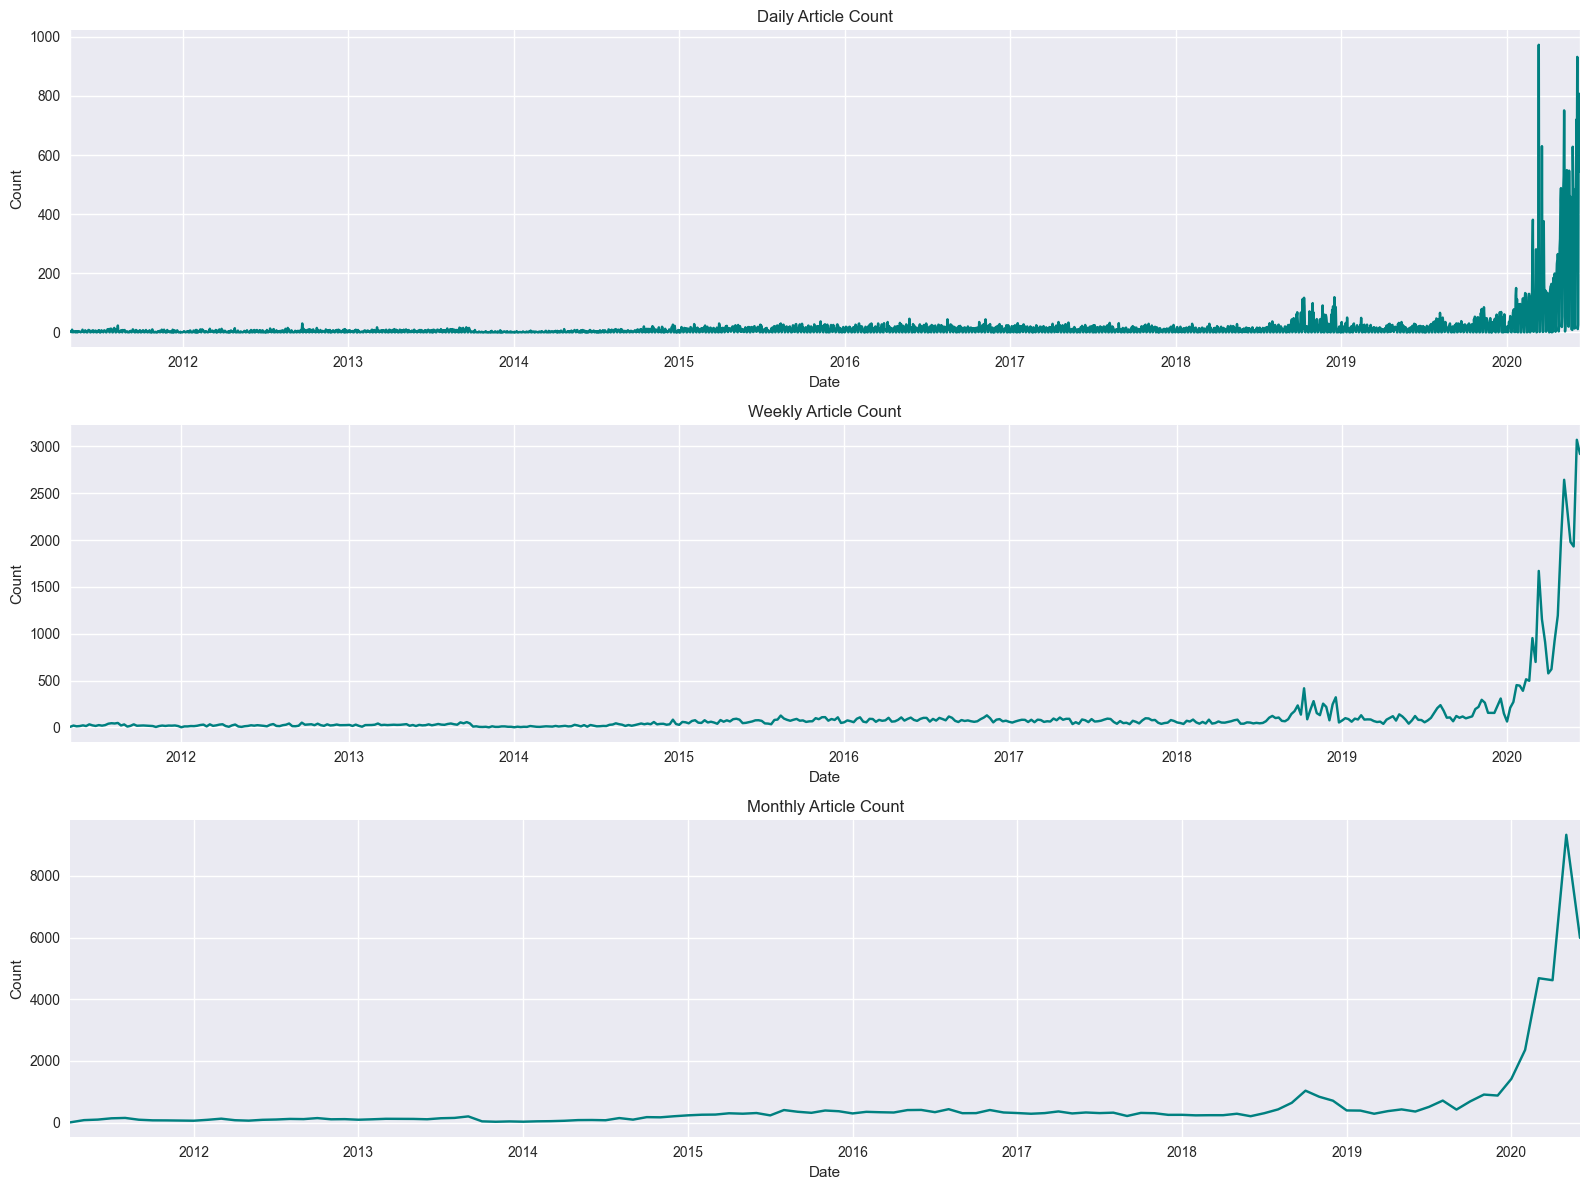


Performing STL decomposition...


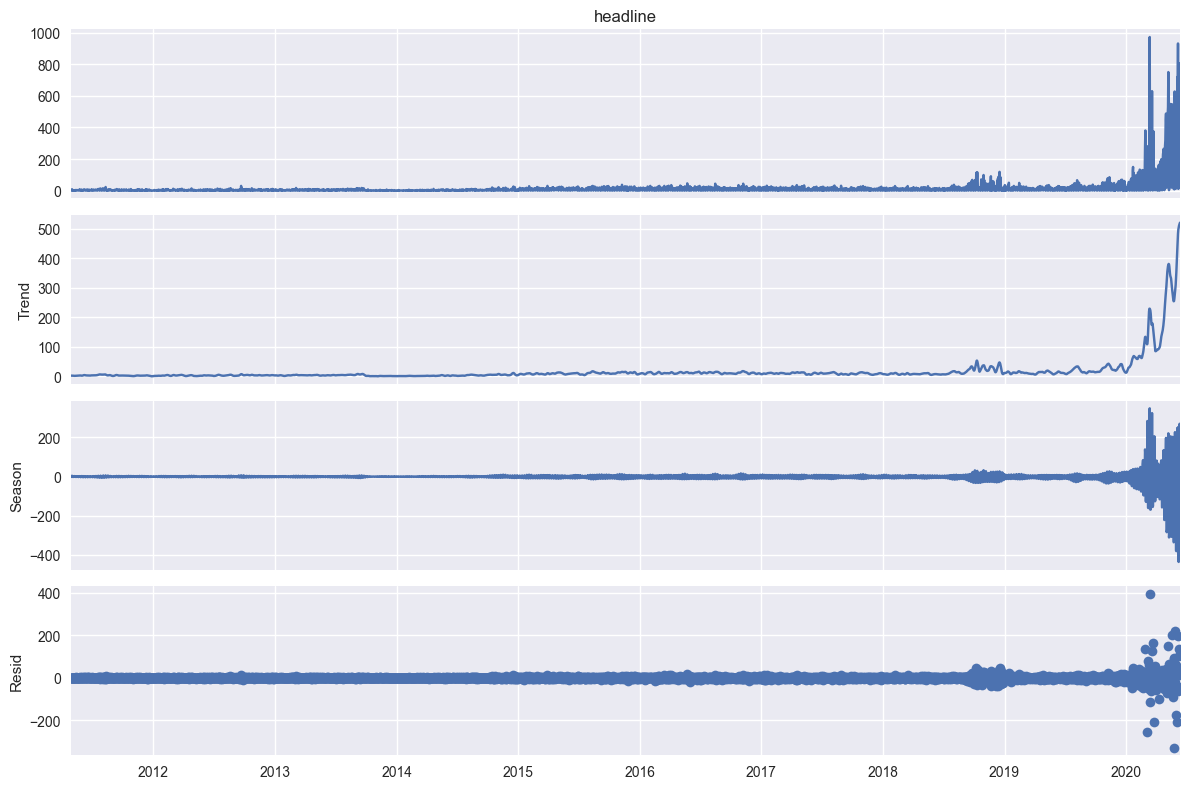

In [7]:
print("\n=== TIME SERIES ANALYSIS ===")

# First ensure we have a proper datetime index
if not isinstance(df.index, pd.DatetimeIndex):
    try:
        # Try parsing without assuming timezone first
        df.index = pd.to_datetime(df.index, errors='coerce')
        
        # Check if we have any NaT values from failed parsing
        if df.index.isna().any():
            # Try alternative parsing methods
            try:
                # Try ISO8601 format
                df.index = pd.to_datetime(df.index, format='ISO8601', errors='raise')
            except:
                # Try mixed formats as last resort
                df.index = pd.to_datetime(df.index, format='mixed', errors='raise')
        
        # Now handle timezone - convert to UTC if timezone exists, otherwise localize
        if df.index.tz is not None:
            print(f"Timezone detected: {df.index.tz} - converting to UTC")
            df.index = df.index.tz_convert('UTC')
        else:
            print("No timezone detected - localizing as UTC")
            df.index = df.index.tz_localize('UTC')
            
    except Exception as e:
        print(f"Could not convert index to datetime: {str(e)}")
        print("Sample values that failed conversion:")
        print(df.index[df.index.isna()][:5])  # Show first 5 failed conversions
        raise

    # Enhanced resampling with multiple time periods
try:
    # Create multiple time aggregations with updated frequency aliases
    time_metrics = {
        'Daily': df['headline'].resample('D').count(),
        'Weekly': df['headline'].resample('W').count(),
        'Monthly': df['headline'].resample('ME').count()  # Changed 'M' to 'ME'
    }
    
    # Plot time series
    plt.figure(figsize=(16, 12))
    for i, (name, series) in enumerate(time_metrics.items(), 1):
        plt.subplot(3, 1, i)
        series.plot(color='teal')
        plt.title(f'{name} Article Count')
        plt.xlabel('Date')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # STL Decomposition of daily data
    if len(time_metrics['Daily']) >= 2*7:  # Need at least 2 periods for STL
        print("\nPerforming STL decomposition...")
        daily_series = time_metrics['Daily'].fillna(0)
        decomp = STL(daily_series, period=7).fit()
        
        fig = decomp.plot()
        fig.set_size_inches(12, 8)
        plt.tight_layout()
        plt.show()
    else:
        print("\nInsufficient data for STL decomposition (need at least 2 weeks of data)")
    
except Exception as e:
    print(f"Time series error: {str(e)}")
    print("Sample of datetime index:")
    print(df.index[:5])  # Show first 5 dates for debugging


=== PUBLISHER ANALYSIS ===
Calculating sentiment metrics...


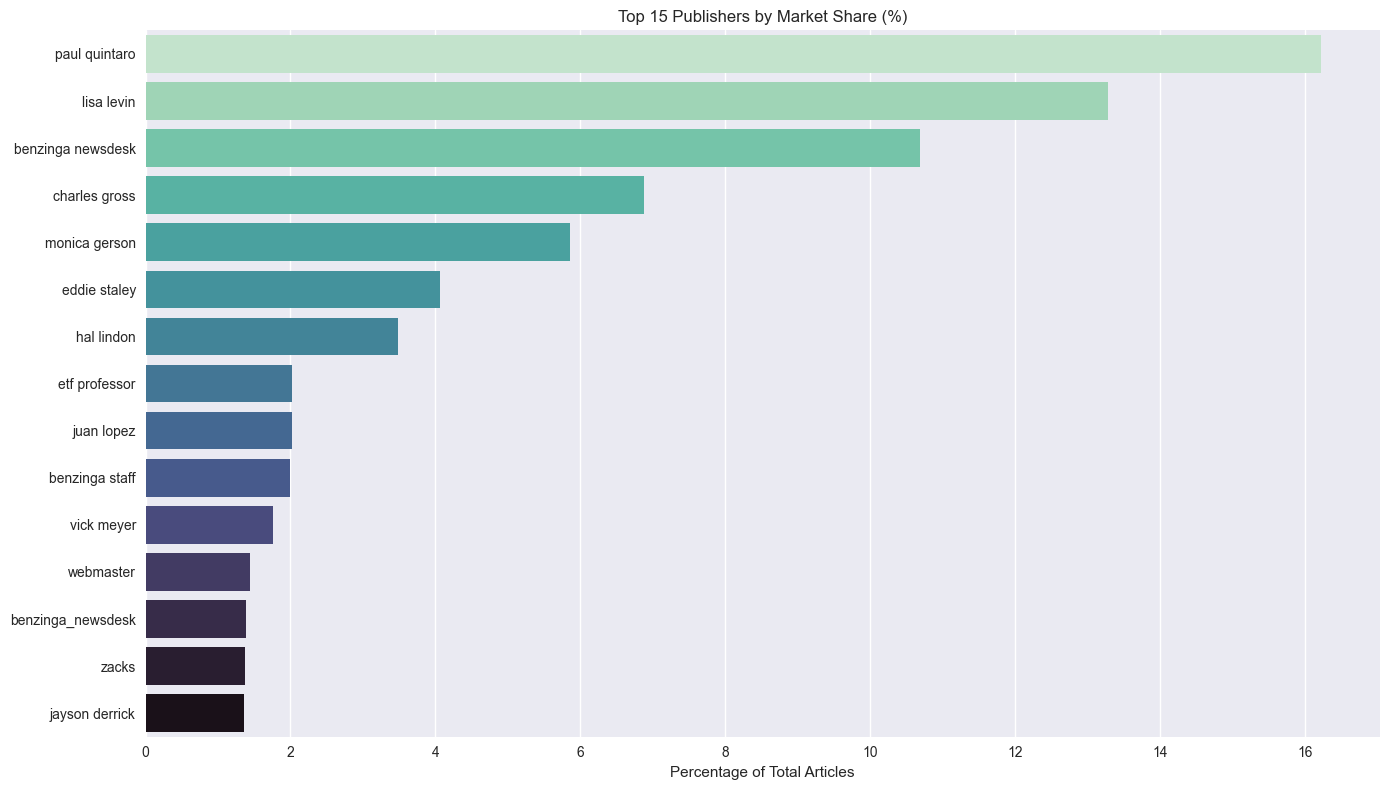

In [8]:
print("\n=== PUBLISHER ANALYSIS ===")

# Enhanced domain extraction
def extract_domain(publisher):
    publisher = str(publisher).lower()
    if '@' in publisher:
        return publisher.split('@')[-1].split('.')[0]
    elif 'www.' in publisher:
        return publisher.split('www.')[-1].split('.')[0]
    elif '://' in publisher:
        return publisher.split('://')[1].split('.')[0]
    return publisher

df['publisher_domain'] = df['publisher'].apply(extract_domain)

# Calculate sentiment with polarity and subjectivity
print("Calculating sentiment metrics...")
df['polarity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Publisher market share with top N
top_n = 15
publisher_stats = df['publisher_domain'].value_counts(normalize=True).head(top_n) * 100

# Enhanced visualization with corrected palette usage
plt.figure(figsize=(14, 8))
sns.barplot(
    y=publisher_stats.index, 
    x=publisher_stats.values,
    hue=publisher_stats.index,  # Added hue parameter
    palette='mako_r', 
    dodge=False,  # Prevent splitting by hue
    legend=False  # Hide legend since we don't need it
)
plt.title(f'Top {top_n} Publishers by Market Share (%)')
plt.xlabel('Percentage of Total Articles')
plt.ylabel('')
plt.tight_layout()
plt.show()

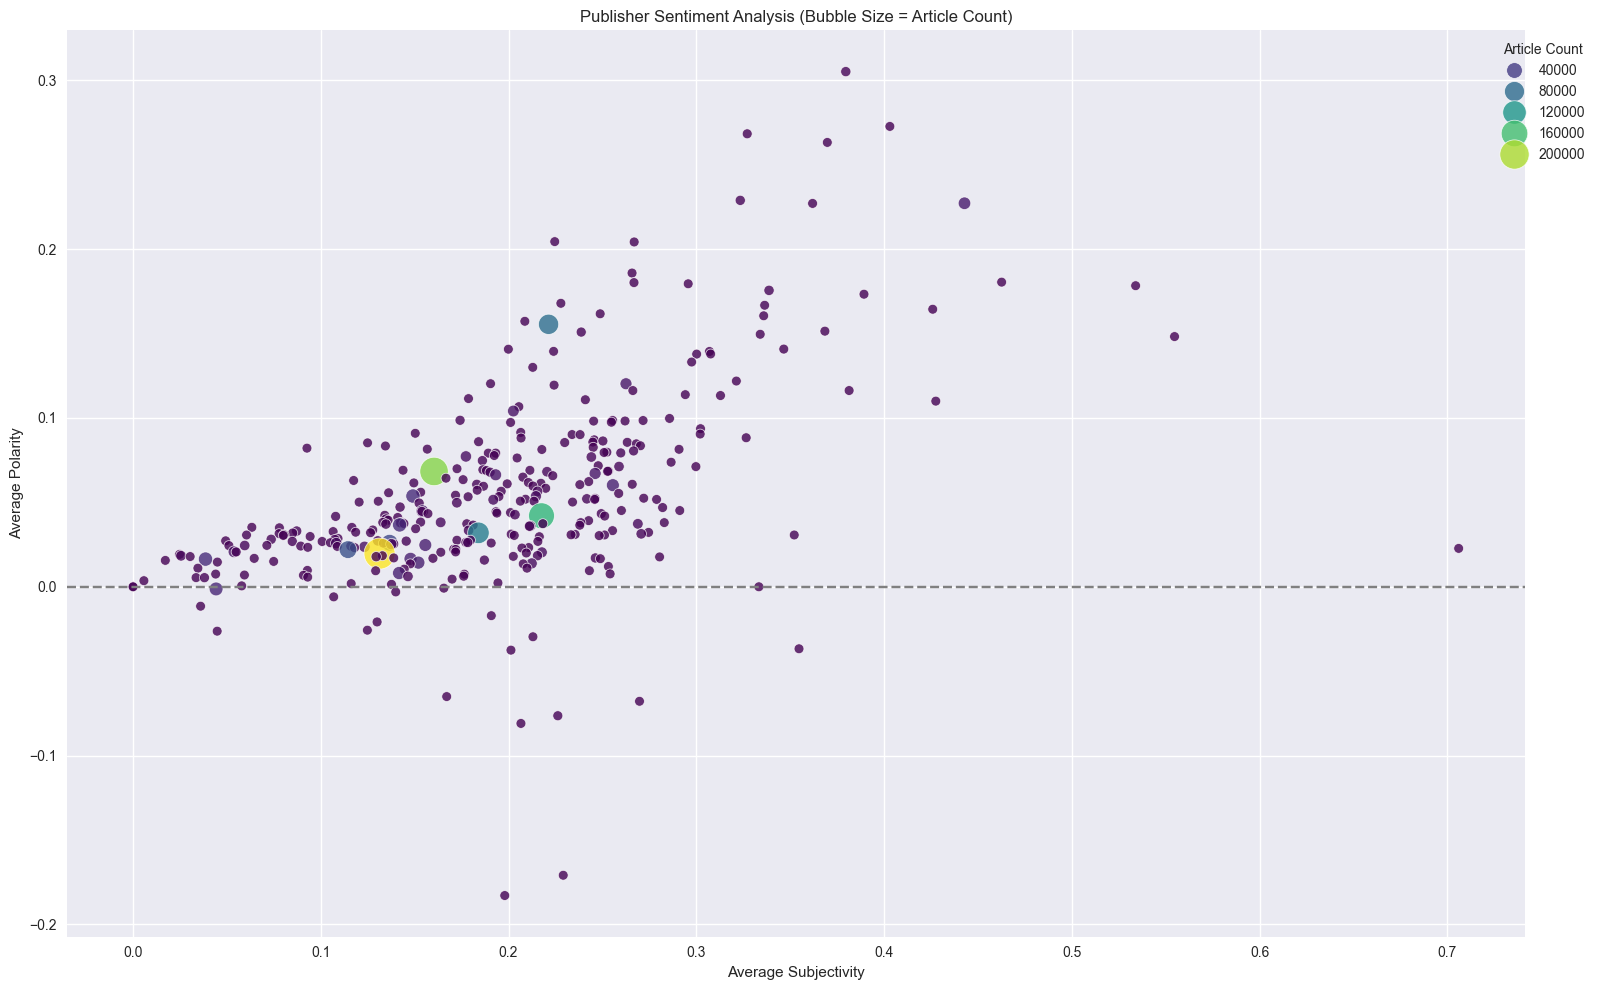

In [9]:
# Sentiment Analysis by Publisher
# Filter publishers with sufficient articles
min_articles = 50
qualified_pubs = df['publisher_domain'].value_counts()[lambda x: x >= min_articles].index

# Sentiment analysis
pub_sentiment = df[df['publisher_domain'].isin(qualified_pubs)].groupby('publisher_domain').agg({
    'polarity': ['mean', 'count'],
    'subjectivity': 'mean'
}).droplevel(0, axis=1)
pub_sentiment.columns = ['avg_polarity', 'article_count', 'avg_subjectivity']
pub_sentiment = pub_sentiment.sort_values('avg_polarity', ascending=False)

# Enhanced visualization
plt.figure(figsize=(16, 10))
sns.scatterplot(data=pub_sentiment, x='avg_subjectivity', y='avg_polarity',
                size='article_count', sizes=(50, 500), hue='article_count',
                palette='viridis', alpha=0.8)
plt.title('Publisher Sentiment Analysis (Bubble Size = Article Count)')
plt.xlabel('Average Subjectivity')
plt.ylabel('Average Polarity')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Article Count', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [10]:
# Save Results and Summary
print("\n=== ANALYSIS COMPLETE ===")

# Save processed data
output_files = {
    'processed_data': 'processed_financial_news.csv',
    'topic_model': 'discovered_topics.csv',
    'publisher_stats': 'publisher_sentiment_stats.csv'
}

df.to_csv(output_files['processed_data'])
pd.DataFrame(topic_results).to_csv(output_files['topic_model'])
pub_sentiment.to_csv(output_files['publisher_stats'])

print("Saved output files:")
for desc, path in output_files.items():
    print(f"- {desc}: {path}")
    
print("\nKey Insights:")
print(f"- Analyzed {len(df)} news articles from {df['publisher_domain'].nunique()} publishers")
print(f"- Discovered {len(topic_results)} key topics in the financial news")
print(f"- Average headline polarity: {df['polarity'].mean():.2f} (range {-1} to 1)")


=== ANALYSIS COMPLETE ===
Saved output files:
- processed_data: processed_financial_news.csv
- topic_model: discovered_topics.csv
- publisher_stats: publisher_sentiment_stats.csv

Key Insights:
- Analyzed 1407328 news articles from 1023 publishers
- Discovered 5 key topics in the financial news
- Average headline polarity: 0.05 (range -1 to 1)
